In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

## Read CSV

In [2]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/GISMA/ML/FinalProject/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(path)
print(df.shape)
df.head()

Mounted at /content/drive
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Study data

In [3]:
df.info() # We can see that TotalCharges should be a float64 but it's a object. We should convert it and check again if any value if empty

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
# We can see that there are 7032 values and should be 7043. We cannot calculate TotalCharges because even with tenure and MonthlyCharges, we can't be sure the MontlhyCharge was always the same.
df.dropna(subset=['TotalCharges'], inplace=True)
# Now check the data type again
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 
 17  

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
# CHeck possible values for each feature
for column in df.columns:
    if df[column].dtype == 'object' or df[column].dtype == 'int64':
        print(column)
        unique_values = df[column].unique()
        print(unique_values)

customerID
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
['Female' 'Male']
SeniorCitizen
[0 1]
Partner
['Yes' 'No']
Dependents
['No' 'Yes']
tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService
['No' 'Yes']
MultipleLines
['No phone service' 'No' 'Yes']
InternetService
['DSL' 'Fiber optic' 'No']
OnlineSecurity
['No' 'Yes' 'No internet service']
OnlineBackup
['Yes' 'No' 'No internet service']
DeviceProtection
['No' 'Yes' 'No internet service']
TechSupport
['No' 'Yes' 'No internet service']
StreamingTV
['No' 'Yes' 'No internet service']
StreamingMovies
['No' 'Yes' 'No internet service']
Contract
['Month-to-month' 'One year' 'Two year']
PaperlessBilling
['Yes' 'No']
PaymentMethod
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (autom

## Visualize data

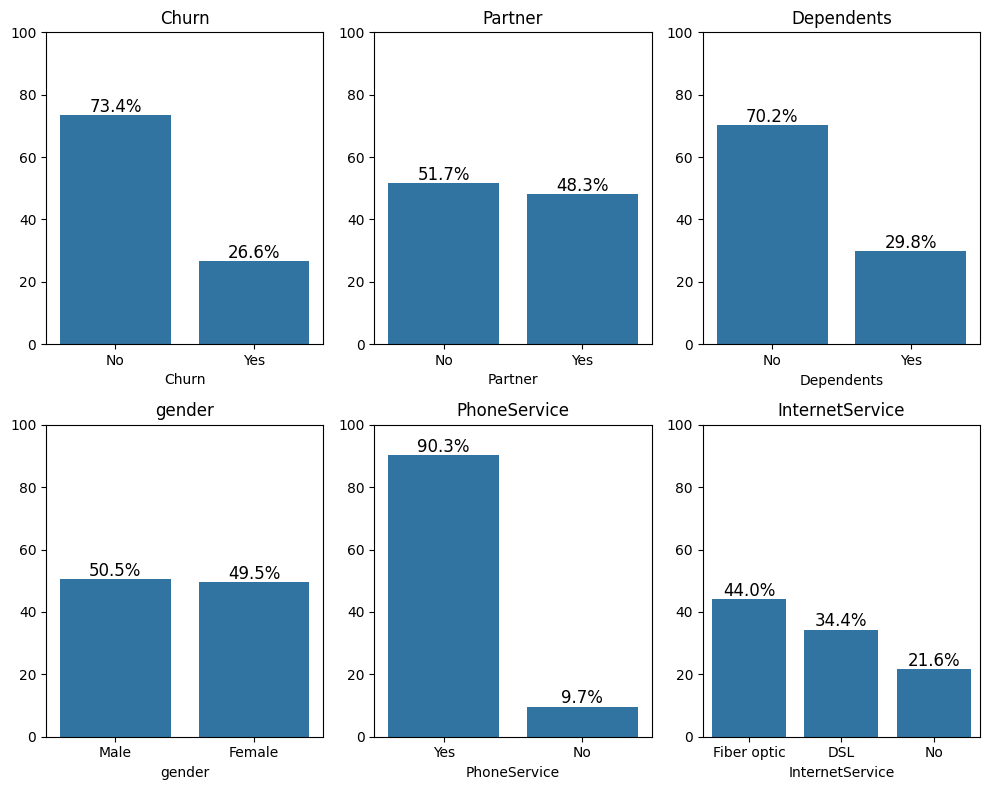

In [7]:
columns_to_plot = ["Churn", "Partner", "Dependents", "gender", "PhoneService", "InternetService"]

n_cols = 3
n_rows = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 8))

for idx, column in enumerate(columns_to_plot):
    row = idx // n_cols
    col = idx % n_cols

    value_counts = df[column].value_counts(normalize=True) * 100

    sns.barplot(x=value_counts.index, y=value_counts.values, ax=axes[row, col])

    ## The code between comments is an AI generated snippet
    for i, v in enumerate(value_counts.values):
        axes[row, col].text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12)
    ## AI generated

    axes[row, col].set_xlabel(column)
    axes[row, col].set_title(f"{column}")
    axes[row, col].set_ylim(0, 100)

plt.tight_layout()
plt.show()

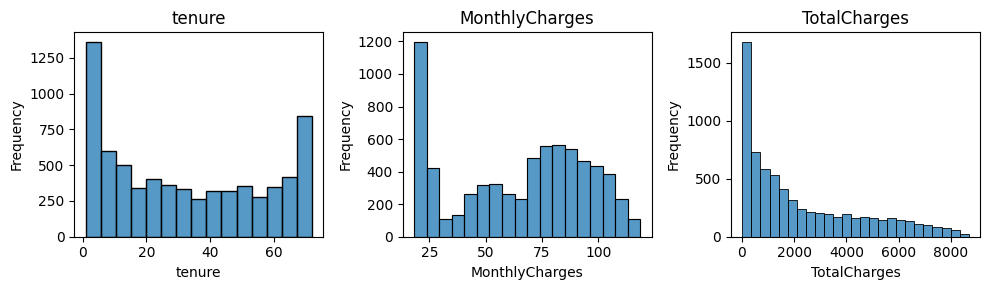

In [8]:
columns_to_plot = ["tenure", "MonthlyCharges", "TotalCharges"]

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for idx, column in enumerate(columns_to_plot):
    sns.histplot(df[column], ax=axes[idx])

    axes[idx].set_title(column)
    axes[idx].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

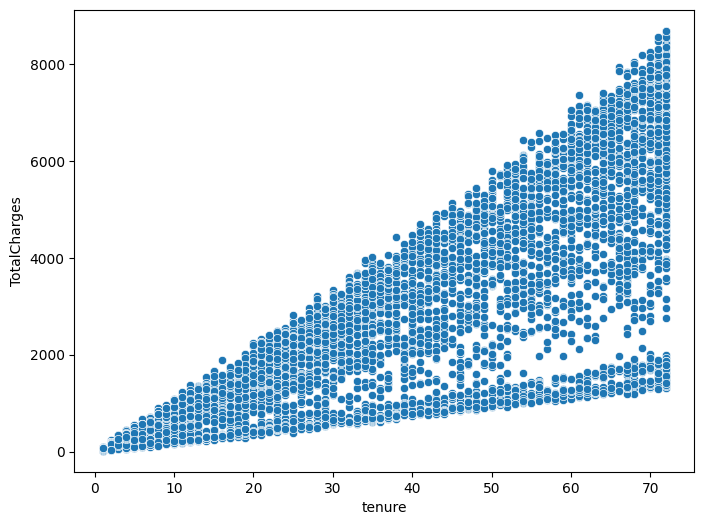

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="tenure", y="TotalCharges")

plt.xlabel("tenure")
plt.ylabel("TotalCharges")

plt.show()

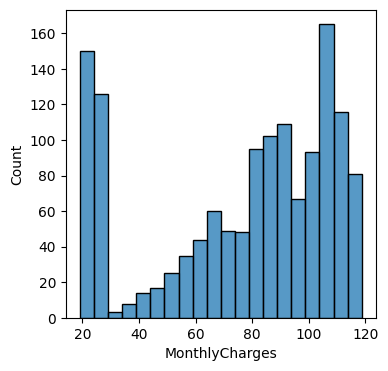

In [10]:
filtered_data = df[df['tenure'] > 60]

plt.figure(figsize=(4, 4))
sns.histplot(filtered_data['MonthlyCharges'], bins=20)

plt.xlabel("MonthlyCharges")

plt.show()

([0, 1, 2, 3],
 [Text(0, 0, 'Electronic check'),
  Text(1, 0, 'Mailed check'),
  Text(2, 0, 'Bank transfer (automatic)'),
  Text(3, 0, 'Credit card (automatic)')])

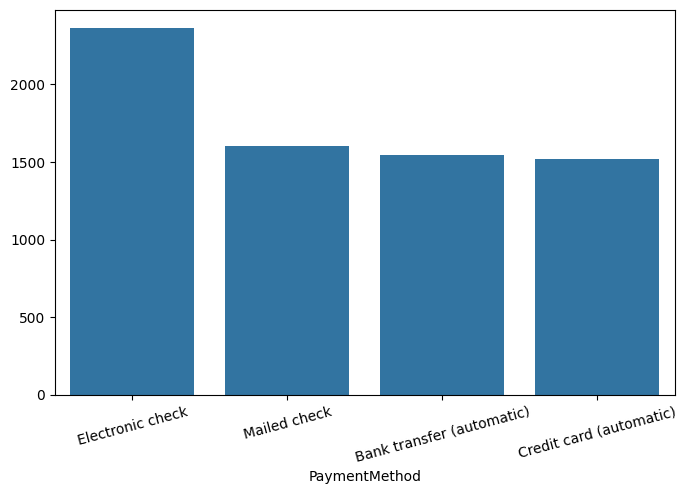

In [11]:
payment_counts = df['PaymentMethod'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=payment_counts.index, y=payment_counts.values)
plt.xlabel("PaymentMethod")
plt.xticks(rotation=15)

### Conclusion

As we can evaluate from the histogram, we see that most of the customers are either new or have been a customer for over 60 months. The company might say that it is important to pay more attention to the new clients since the curve shows that more than a half will churn. Also, most clients have a low ticket. I would investigate the ticket of the long term customers.

The second graph shows that the customer that have been to the company longer, spend more money more frequently, compared to the overall graph of monthly charge. This helps the company conclude that would be a great idea to spend money on the customer satisfaction of customer that signed the contract longer than 60 months.

## Data cleaning

### Analyzes

After studing the data, it was possible to conclude that customerID won't help with the model. Also, the missing data for TotalCharges is so low that we can get rid of those rows.

In [12]:
def transform_data(df):

  ## In the fields bellow, it is exaclty just appling the idea of one hot encoding
  df['isMale'] = df['gender'].map({'Male': 1, 'Female': 0})
  df['isPaperlessBilling'] = df['PaperlessBilling'].map({'Yes': 1, 'No': 0})
  df['hasPartner'] = df['Partner'].map({'Yes': 1, 'No': 0})
  df['hasDependents'] = df['Dependents'].map({'Yes': 1, 'No': 0})
  df['hasPhoneService'] = df['PhoneService'].map({'Yes': 1, 'No': 0})
  df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

  mapping_internet_based = { 'No internet service': -1, 'No': 0, 'Yes': 1}
  # Apply the custom mapping to each column
  for col in ['OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
      df[col] = df[col].map(mapping_internet_based)

  mapping_phone_based = { 'No phone service': -1, 'No': 0, 'Yes': 1}
  df['MultipleLines'] = df['MultipleLines'].map(mapping_phone_based)

  mapping_contract = { 'Month-to-month': 1, 'One year': 12, 'Two year': 24}
  df['Contract'] = df['Contract'].map(mapping_contract)

  df['PaymentMethod'] = df['PaymentMethod'].map({'Electronic check': 'EletronicCheck', 'Mailed check': 'MailedCheck', 'Bank transfer (automatic)': 'BankTransfer', 'Credit card (automatic)':
  'CreditCard'})
  df['InternetService'] = df['InternetService'].map({'Fiber optic': 'FiberOptic'})
  df = pd.get_dummies(df, columns=['PaymentMethod', 'InternetService'], dtype=int)


  df = df.drop(['customerID','gender', 'PaperlessBilling', 'Partner', 'Dependents', 'PhoneService'], axis=1)
  return df

In [13]:
df = transform_data(df)
pd.set_option('display.max_columns', None)

df.head()

,SeniorCitizen,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn,isMale,isPaperlessBilling,hasPartner,hasDependents,hasPhoneService,PaymentMethod_BankTransfer,PaymentMethod_CreditCard,PaymentMethod_EletronicCheck,PaymentMethod_MailedCheck,InternetService_FiberOptic
0,0,1,-1,0,1,0,0,0,0,1,29.85,29.85,0,0,1,1,0,0,0,0,1,0,0
1,0,34,0,1,0,1,0,0,0,12,56.95,1889.50,0,1,0,0,0,1,0,0,0,1,0
2,0,2,0,1,1,0,0,0,0,1,53.85,108.15,1,1,1,0,0,1,0,0,0,1,0
3,0,45,-1,1,0,1,1,0,0,12,42.30,1840.75,0,1,0,0,0,0,1,0,0,0,0
4,0,2,0,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,0,1,0,0,1,0,1


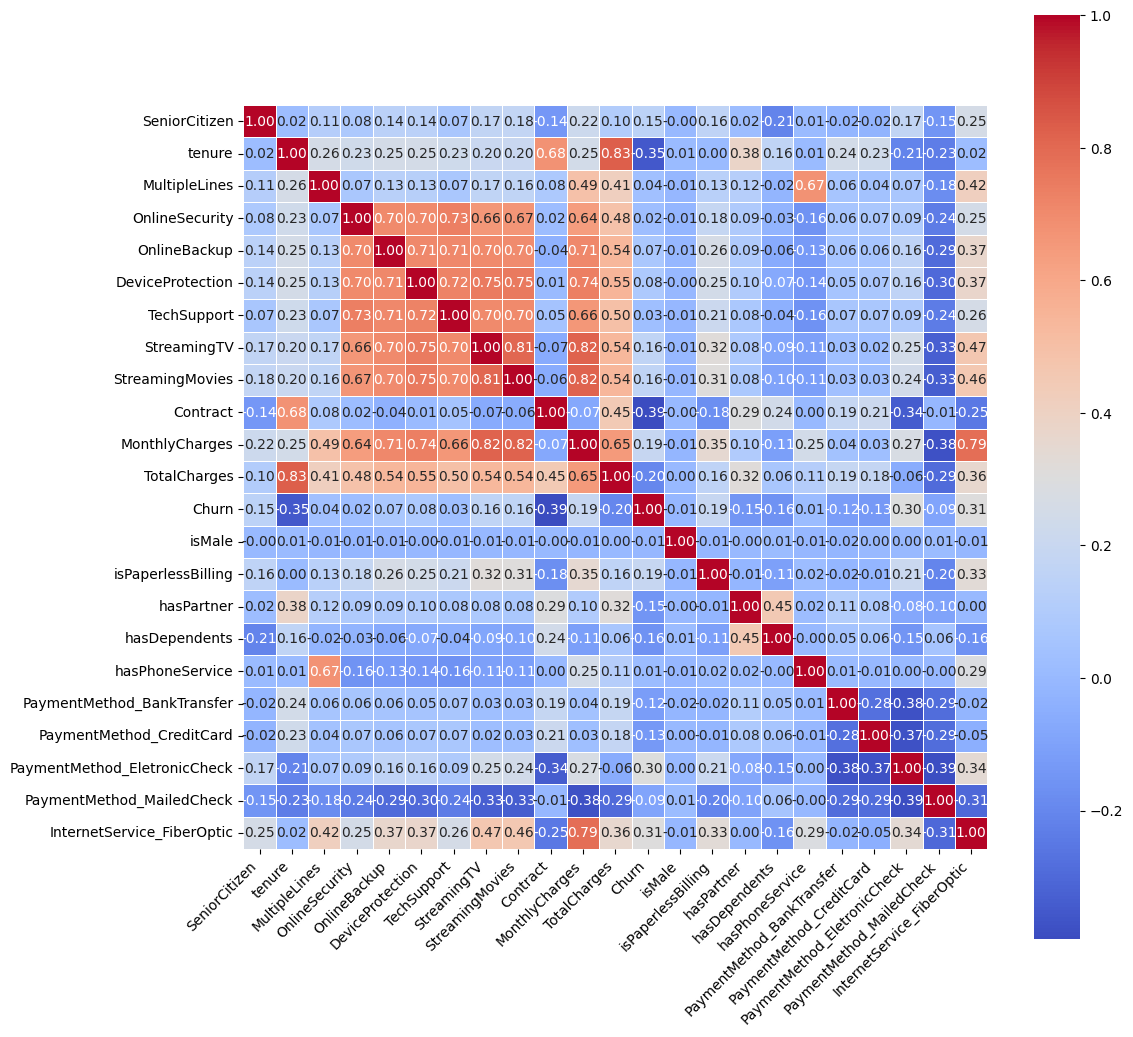

In [14]:
plt.figure(figsize=(12, 12))

sns.heatmap( df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5,square=True)

plt.xticks(rotation=45, ha='right')

plt.show()

## Split data and data preparation

In [15]:
X = df.drop('Churn', axis=1) # Features (remember to use the name of the target column in your data, for my dataset it is simply 'target')
y = df['Churn'] # Target or labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shapes:", X_train_scaled.shape, y_train.shape)
print("Test set shapes:", X_test_scaled.shape, y_test.shape)

Training set shapes: (5625, 22) (5625,)
Test set shapes: (1407, 22) (1407,)


## Implement Logistic regression

In [16]:
## To implement grid search, it was necessary to create a list of a map of possible values for each hyperparameter on the
## LogisticRegression model, since the solver used in this model changes the possible hyperparameters.
param_grid = [
    {'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga'], 'C': [0.01, 0.1, 1, 10, 100], 'max_iter': [100,200, 500]},
    {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.01, 0.1, 1, 10, 100],
     'l1_ratio': [0.1, 0.5, 1], 'max_iter': [100,200, 500]}
]


kfold = KFold(n_splits=5, shuffle=True, random_state=32)

logistic_regression = LogisticRegression(random_state=32)
## K-fold is implemented in GridSearchCV using the cv param. The default value is 5 as documented here:
## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV
## In my model, I decided to shuffle, split in 5, like the default and
grid_search_recall = GridSearchCV(logistic_regression, param_grid, cv=kfold, scoring='recall')
grid_search_accuracy = GridSearchCV(logistic_regression, param_grid, cv=kfold, scoring='accuracy')

grid_search_recall.fit(X_train_scaled, y_train)
grid_search_accuracy.fit(X_train_scaled, y_train)

best_model_recall = grid_search_recall.best_estimator_
best_model_accuracy = grid_search_accuracy.best_estimator_

y_pred_LogisticRegression_recall = best_model_recall.predict(X_test_scaled)
y_pred_LogisticRegression_accuracy = best_model_accuracy.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test, y_pred_LogisticRegression_recall)*100}')
print(f'Accuracy: {accuracy_score(y_test, y_pred_LogisticRegression_accuracy)*100}')

Accuracy: 79.03340440653874
Accuracy: 79.03340440653874


In [17]:
print(f'Accuracy - Recall scoring: {accuracy_score(y_test, y_pred_LogisticRegression_recall)*100}')
print(f'Recall - Recall scoring: {recall_score(y_test, y_pred_LogisticRegression_recall)*100}')

print(f'Accuracy - Accuracy scoring: {accuracy_score(y_test, y_pred_LogisticRegression_accuracy)*100}')
print(f'Recall - Accuracy scoring: {recall_score(y_test, y_pred_LogisticRegression_accuracy)*100}')

Accuracy - Recall scoring: 79.03340440653874
Recall - Recall scoring: 51.60427807486631
Accuracy - Accuracy scoring: 79.03340440653874
Recall - Accuracy scoring: 51.60427807486631


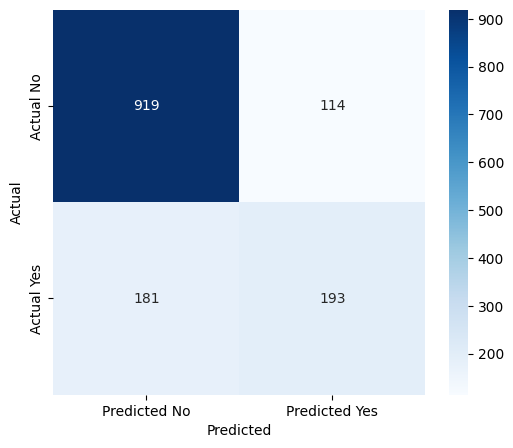

In [18]:
cm = confusion_matrix(y_test, y_pred_LogisticRegression_recall)

TN, FP, FN, TP = cm.ravel()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Implement SVM

In [19]:
svm = SVC(random_state=32)
kfold = KFold(n_splits=5, shuffle=True, random_state=32)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_SVM = GridSearchCV(svm, param_grid, cv=kfold, scoring='accuracy')

grid_search_SVM.fit(X_train_scaled, y_train)

best_svm = grid_search_SVM.best_estimator_

y_pred_SVM = best_svm.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test, y_pred_SVM)*100}%')

Accuracy: 78.74911158493248%


In [20]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_SVM)*100}')
print(f'Recall: {recall_score(y_test, y_pred_SVM)*100}')

Accuracy: 78.74911158493248
Recall: 47.32620320855615


### Evaluation of SVM

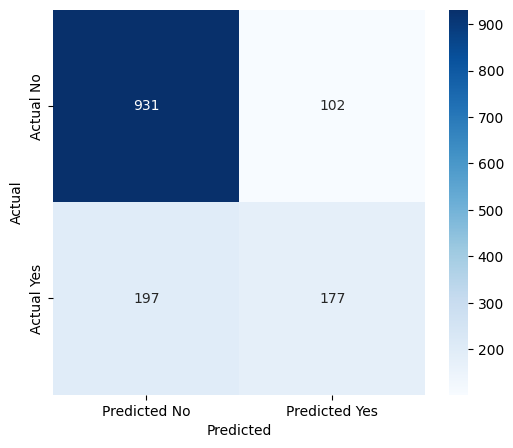

In [21]:
cm = confusion_matrix(y_test, y_pred_SVM)

TN, FP, FN, TP = cm.ravel()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()